EDA --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3)  
RF/XGB/LGBM & model explaination --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-rf-xgb-lgbm-model-explaination-s4e3)  
Origin vs. Train datasets, effect of adding original dataset on model score --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-effect-of-adding-original-data-s4e3)  
Data balancing effect --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-data-balance-effect-s4e3)  
Dropping unimportant features effect --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-drop-unimportant-features-s4e3)

### Objective

- Study feature engineering technique: **Principle Component Analysis** (PCA)
- How to choose features to generate PCA features?
- Scaler effect?
- Can model prediction power increase by including PCA features?

In [1]:
# setup environment
input_path = './data/'
output_path = './output06/'
verbose = 1

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance
import shap

import pickle

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

In [2]:
# load raw data
df_train_raw = pd.read_csv(input_path + 'train.csv') # train dataset
df_test_raw = pd.read_csv(input_path + 'test.csv') # test dataset
df_origin_raw = pd.read_csv(input_path + 'Steel Plates Faults.csv') # original dataset

# X transformer function
def X_transformer(X_raw):
    X = X_raw.copy()
    X['X_Center'] = (X['X_Maximum'] + X['X_Minimum'])/2
    X['X_Range'] = X['X_Maximum'] - X['X_Minimum']
    X['Y_Center'] = (X['Y_Maximum'] + X['Y_Minimum'])/2
    X['Y_Range'] = X['Y_Maximum'] - X['Y_Minimum']
    X['Aspect_Ratio'] = X['Y_Perimeter'] / X['X_Perimeter']
    X['Mean_Luminosity'] = X['Sum_of_Luminosity'] / X['Pixels_Areas']
    X['Delta_Luminosity'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']
    X['Log_Pixel_Resolution'] = ((10**X['LogOfAreas']) / X['Pixels_Areas']).apply(np.log10)
    if 'id' in X.columns:
        X.drop(columns=['id'], inplace=True)
    return X

df_origin = X_transformer(df_origin_raw)
df_train = X_transformer(df_train_raw)
df_test = X_transformer(df_test_raw)

predict_features = df_train_raw.columns.to_list()[-7:]
cat_features = ['TypeOfSteel_A300', 'TypeOfSteel_A400', 
                'Outside_Global_Index', 'Log_Pixel_Resolution']
num_features = df_train.drop(columns=predict_features+cat_features).columns.to_list()

# split train, val datasets
stratify = pd.Series(np.zeros(df_train.shape[0]), 
                     index=df_train.index, name='stratify')
for defect in predict_features:
    stratify = 10*stratify + df_train[defect]
## combine dual labelled groups to avoid split error (only 1 row in a group)
stratify = stratify.apply(lambda x: 10001 if x in [10010, 1010000] else x)
## split
train_stratify, val_stratify = \
    train_test_split(stratify, test_size=0.25, 
                     stratify=stratify, random_state=42)

# combine origin dataset into tail of train dataset
df_train = pd.concat([df_train, df_origin], axis=0).\
              reset_index(drop=True)

Principle component analysis (PCA) is a great way to engineer new features which may potentially improve model prediction power. However, deciding which features be used to conduct PCA can be quite tricky. Usually it requires domain knowledge input or extensive EDA effort.

In this notebook we experiment a new algorithm to **auto select features** for PCA transformation based on **correlation matrix** search:  
1. Generate correlation matrix (convert to absolute values) of all numeric features.
2. Search for groups of features with high correlation (based on predefined criteria) between each other, generate PCA features with them

**NOTE**  
- One feature can appear in multiple feature groups, so final number of PCA features may be bigger than number of original numerical features.
- Scaling can affect PCA result. For this dataset many features are significant skewed, so we try to implement 2 types of scaling before correlation matrix calculation and PCA feature engineer.
    1. StandardScaler
    2. PowerTransformer (improve data normality, will affect correlation factor)

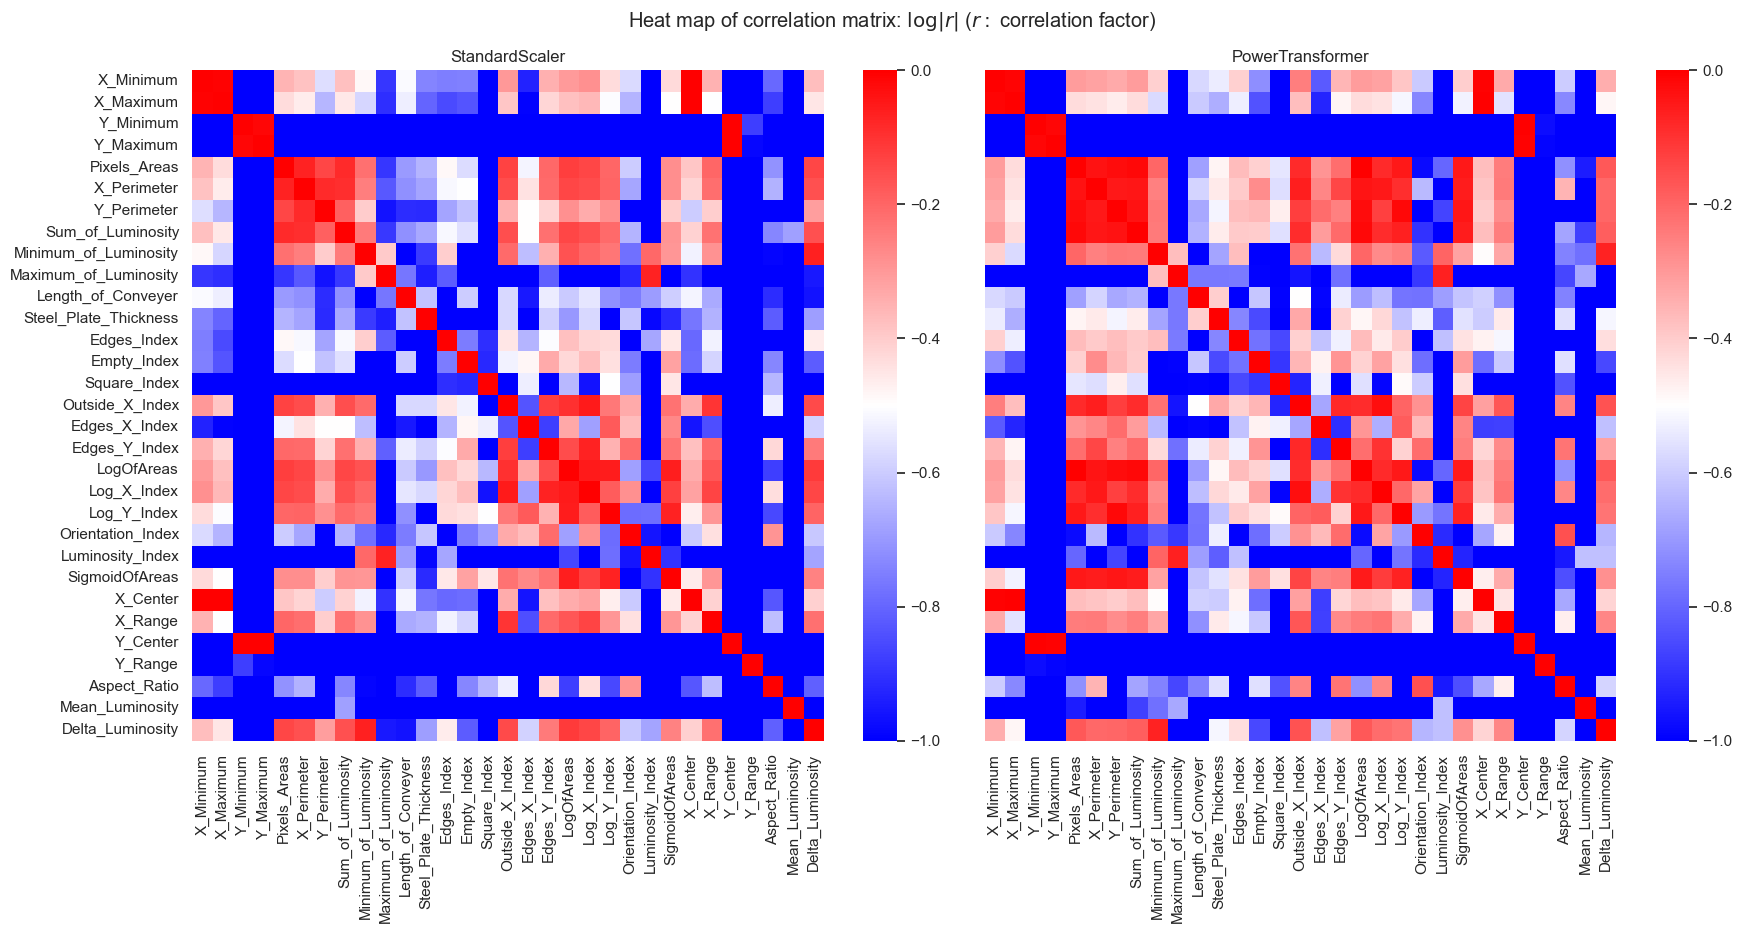

In [3]:
# apply scaler before PCA
scaler = StandardScaler()
pt = PowerTransformer()
scaler.fit(df_train.drop(columns=predict_features)[~df_train.index.isin(val_stratify.index)]) # avoid data leak
pt.fit(df_train.drop(columns=predict_features)[~df_train.index.isin(val_stratify.index)])
df_train_scaler = pd.DataFrame(scaler.transform(df_train.drop(columns=predict_features)), 
                               index=df_train.index, columns=df_train.drop(columns=predict_features).columns)
df_train_pt = pd.DataFrame(pt.transform(df_train.drop(columns=predict_features)),
                           index=df_train.index, columns=df_train.drop(columns=predict_features).columns)

# plot corr_factor with different scaler
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 9.5))
sns.heatmap(np.log10(df_train_scaler[num_features].corr().abs()), vmax=0, vmin=-1, cmap='bwr', ax=axs[0])
sns.heatmap(np.log10(df_train_pt[num_features].corr().abs()), vmax=0, vmin=-1, cmap='bwr', ax=axs[1])
fig.suptitle('Heat map of correlation matrix: $\log|r|$ ($r:$ correlation factor)')
axs[0].set_title('StandardScaler')
axs[1].set_title('PowerTransformer')
fig.tight_layout()
fig.show()

In [4]:
def get_pca(df, features, criteria, prefix='', ignore_val=False):
    """find principle components of the features.
    ## Return
    (df_pca, dict_pca)
    - df_pca [DataFrame]: pca components
    - dict_pca [dictionary]: {'featuers': [set of features], 'pca': [transformers]}
    ## Parameters
    - df [DataFrame]
    - features [list]
    - criteria [num]: min abs(corr_factore) to group features for PCA
    - prefix [str]: to be applied to df_pca column names
    - ignore_val [bool]: if True, pca fitting will exclude val dataset to avoid data leak
    """
    df_pca = []
    dict_pca = {'features': [], 'pca': []}
    if ignore_val == False:
        df_corr = df[features].corr().abs()
    else:
        df_corr = df[~df.index.isin(val_stratify.index)][features].corr().abs()
    feature_set = [] # store index of the features
    i = 0
    while True: # find all feature groups
        if i == len(features):
            if len(feature_set) == 0: # finish searching all feature groups
                break # while loop
            # found one possible feature groups
            if len(feature_set) == 1: # feature group with only 1 member, no need to do PCA
                i = feature_set.pop() + 1
                continue # while loop
            # feature group more than 1 member
            f_set_candidate = set([features[j] for j in feature_set])
            add_candidate = True
            for f_set in dict_pca['features']:
                if f_set_candidate.issubset(f_set):
                    add_candidate = False
                    break # for loop
            if add_candidate == True:
                dict_pca['features'].append(f_set_candidate)
            i = feature_set.pop() + 1
            continue # while loop
        # check if new feature can be added into the group
        if len(feature_set) == 0: # empty
            feature_set.append(i)
            i += 1
            continue # while loop
        # feature group not empty
        add_feature = True
        for j in feature_set:
            if df_corr.loc[features[i], features[j]] < criteria:
                add_feature = False
                break # for loop
        if add_feature == True: feature_set.append(i)
        i += 1
    # generate PCA for each feature group
    for feature_set in dict_pca['features']:
        feature_list = list(feature_set)
        pca = PCA(random_state=42)
        if ignore_val == False:
            pca.fit(df[feature_list])
        else:
            pca.fit(df[~df.index.isin(val_stratify.index)][feature_list])
        df_pca.append(pd.DataFrame(pca.transform(df[feature_list]), index=df.index))
        dict_pca['pca'].append(pca)
    # concat df_pca into one single DataFrame
    df_pca = pd.concat(df_pca, axis=1)
    df_pca.columns = [prefix + f'_pca_{i}' for i in range(df_pca.shape[1])]
    return df_pca, dict_pca

def apply_pca(df, dict_pca, prefix=''):
    df_pca = []
    for i in range(len(dict_pca['features'])):
        feature_list = list(dict_pca['features'][i])
        pca = dict_pca['pca'][i]
        df_pca.append(pd.DataFrame(pca.transform(df[feature_list]), index=df.index))
    df_pca = pd.concat(df_pca, axis=1)
    df_pca.columns = [prefix + f'_pca_{i}' for i in range(df_pca.shape[1])]
    return df_pca

Now we can test the effect of including these PCA features in our models.

Simply including all features may not be a good idea. Our [other work](https://www.kaggle.com/code/ustcer1984/steel-plate-drop-unimportant-features-s4e3) indicates dropping unimportant features based on permutation importance shows positive result. We will include this method in below model building.

**Experiment Plan**  
- Compare 4 feature conditions:
    1. Without PCA features
    2. \+ StandardScaler PCA features
    3. \+ PowerTransformer PCA features
    4. \+ StandarScaler & PowerTransformer PCA features
- Study how to choose correlation significance criteria (range 0.2 ~ 0.9, step 0.1)
- Compare RF/XGB/LGBM models
    - n_estimators = 500, learning_rate = 0.02
- Drop unimportant features
    - Use LGBM to build inital model for permutation importance calculation
    - Drop features with permu_importance < 1e-4

In [5]:
# container for pca with different criterias
pca_dict = {'criteria': [], 
            'ss_features': [], # StandardScaler PCA features
            'ss_pca': [],      # pca transformers
            'pt_features': [], # PowerTransformer PCA features
            'pt_pca': []
            }
for criteria in np.arange(0.2, 0.95, 0.1):
    pca_dict['criteria'].append(criteria)
    features, pca = get_pca(df_train_scaler, num_features, criteria, 'ss', ignore_val=True)
    pca_dict['ss_features'].append(features)
    pca_dict['ss_pca'].append(pca)
    features, pca = get_pca(df_train_pt, num_features, criteria, 'pt', ignore_val=True)
    pca_dict['pt_features'].append(features)
    pca_dict['pt_pca'].append(pca)

In [6]:
# find number of pca features per criteria
pca_number = {
    'criteria': pca_dict['criteria'],
    'ss_pca_num': [df.shape[1] for df in pca_dict['ss_features']],
    'pt_pca_num': [df.shape[1] for df in pca_dict['pt_features']]
}
pca_number = pd.DataFrame(pca_number)
pca_number['ss&pt_pca_num'] = pca_number['ss_pca_num'] + pca_number['pt_pca_num']
pca_number

,criteria,ss_pca_num,pt_pca_num,ss&pt_pca_num
0,0.2,159,174,333
1,0.3,96,101,197
2,0.4,68,100,168
3,0.5,45,77,122
4,0.6,51,48,99
5,0.7,36,33,69
6,0.8,26,25,51
7,0.9,6,18,24


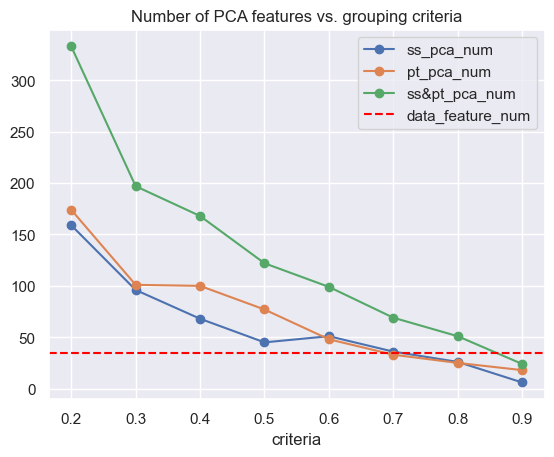

In [7]:
pca_number.set_index('criteria').plot(marker='o')
plt.axhline(35, color='red', ls='--', label='data_feature_num')
plt.legend()
plt.title('Number of PCA features vs. grouping criteria')
plt.show()

In [8]:
# functions to get model score
def get_defect_score(df, model_list, defect):
    """ AUC_score for model built for specific defect prediction
    ## Return
    - auc_score [list]
    ## Parameters
    - df [DataFrame]: train datasets including all defect columns
    - model_list [list]
    - defect [str]: column name of the target defect type
    """
    df_train = df[~df.index.isin(val_stratify.index)]
    df_val = df[df.index.isin(val_stratify.index)]
    X_train = df_train.drop(columns=predict_features)
    y_train = df_train[defect]
    X_val = df_val.drop(columns=predict_features)
    y_val = df_val[defect]
    model = LGBMClassifier(n_estimators=500, learning_rate=0.02, n_jobs=-1, verbose=-1)
    model.fit(X_train, y_train)
    features = [] # container for significant features
    permu_importance = permutation_importance(
            model, X_val, y_val, scoring='roc_auc',
            n_repeats=5, n_jobs=-1, random_state=0
        )['importances_mean']
    if verbose > 2: print('\t\t' + defect + ': permu_importance calculation done!')
    for i in range(X_val.shape[1]):
        feature = X_val.columns.to_list()[i]
        if permu_importance[i] > 1e-4:
            features.append(feature)
    auc_score = []
    # use val dataset
    for model in model_list:
        model.fit(X_train[features], y_train)
        y_score = model.predict_proba(X_val[features])[:, 1]
        score = metrics.roc_auc_score(y_val, y_score)
        auc_score.append(score)
    # # use cv method
    # X = df[features]
    # y = df[defect]
    # for model in model_list:
    #     score = cross_val_score(estimator=model,
    #                             X=X, y=y,
    #                             cv=5, n_jobs=-1,
    #                             scoring='roc_auc'
    #                             ).mean()
    #     auc_score.append(score)
    return auc_score
def get_avg_score(df, model_list):
    """ average AUC_score of models for all defect types
    """
    auc_score = [0 for model in model_list]
    for defect in predict_features:
        scores = get_defect_score(df, model_list, defect)
        for i in range(len(model_list)):
            auc_score[i] += scores[i]
    auc_score = [score/len(predict_features) for score in auc_score]
    return auc_score

In [9]:
summary = {
    'features': ['ref'], # 'ref', '+ss_pca', '+pt_pca', '+ss&pt_pca'
    'criteria': [np.nan], # criteria for feature grouping for pca
    'RF':       [], # auc_score of RF model
    'XGB':      [], # auc_score of XGB model
    'LGBM':     []  # auc_score of LGBM model
}
model_dict = {
    'RF': RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=314),
    'XGB': XGBClassifier(n_estimators=500, n_jobs=-1, random_state=314, learning_rate=0.02),
    'LGBM': LGBMClassifier(n_estimators=500, n_jobs=-1, random_state=314, learning_rate=0.02, verbose=-1)
}
model_list = [
    model_dict['RF'],
    model_dict['XGB'],
    model_dict['LGBM']
]
# calculate score for ref condition (no pca features)
if verbose > 0: print('Calculate score for ref condition:')
scores = get_avg_score(df_train, model_list)
summary['RF'].append(scores[0])
summary['XGB'].append(scores[1])
summary['LGBM'].append(scores[2])
if verbose > 0: print('Done!')
# calculate score for each criteria
for i in range(len(pca_dict['criteria'])):
    criteria = pca_dict['criteria'][i]
    ss_features = pca_dict['ss_features'][i]
    pt_features = pca_dict['pt_features'][i]
    if verbose > 0: print(f'criteria = {criteria:.1f}')
    for condition in ['+ss_pca', '+pt_pca', '+ss&pt_pca']:
        if verbose > 1: print('\tcondition = ' + condition)
        summary['criteria'].append(np.round(criteria, 1))
        summary['features'].append(condition)
        if condition == '+ss_pca':
            df_train_pca = pd.concat([df_train, ss_features], axis=1)
        elif condition == '+pt_pca':
            df_train_pca = pd.concat([df_train, pt_features], axis=1)
        else:
            df_train_pca = pd.concat([df_train, ss_features, pt_features], axis=1)
        scores = get_avg_score(df_train_pca, model_list)
        summary['RF'].append(scores[0])
        summary['XGB'].append(scores[1])
        summary['LGBM'].append(scores[2])
        if verbose > 1: print('\tDone!')
    if verbose > 0: print('Done!')

pickle.dump(summary, open(output_path+'summary.pickle', 'wb'))
summary = pickle.load(open(output_path+'summary.pickle', 'rb'))

Calculate score for ref condition:
Done!
criteria = 0.2
Done!
criteria = 0.3
Done!
criteria = 0.4
Done!
criteria = 0.5
Done!
criteria = 0.6
Done!
criteria = 0.7
Done!
criteria = 0.8
Done!
criteria = 0.9
Done!


In [10]:
df_summary = pd.DataFrame(summary)
for col in df_summary.columns[2:]:
    df_summary[col+'_diff'] = df_summary[col] - df_summary.loc[0, col]
df_summary

,features,criteria,RF,XGB,LGBM,RF_diff,XGB_diff,LGBM_diff
0,ref,NaN,0.876858,0.884997,0.886670,0.000000,0.000000,0.000000
1,+ss_pca,0.2,0.878609,0.886636,0.889024,0.001750,0.001639,0.002354
2,+pt_pca,0.2,0.872762,0.886734,0.889012,-0.004096,0.001737,0.002342
3,+ss&pt_pca,0.2,0.874979,0.886893,0.890018,-0.001879,0.001896,0.003348
4,+ss_pca,0.3,0.873804,0.886474,0.887177,-0.003054,0.001477,0.000507
5,+pt_pca,0.3,0.873591,0.886169,0.887460,-0.003268,0.001172,0.000790
6,+ss&pt_pca,0.3,0.874409,0.886632,0.887296,-0.002449,0.001634,0.000626
7,+ss_pca,0.4,0.875052,0.887558,0.888460,-0.001807,0.002561,0.001790
8,+pt_pca,0.4,0.875047,0.887284,0.889602,-0.001811,0.002286,0.002932
9,+ss&pt_pca,0.4,0.873565,0.887069,0.888610,-0.003293,0.002072,0.001941


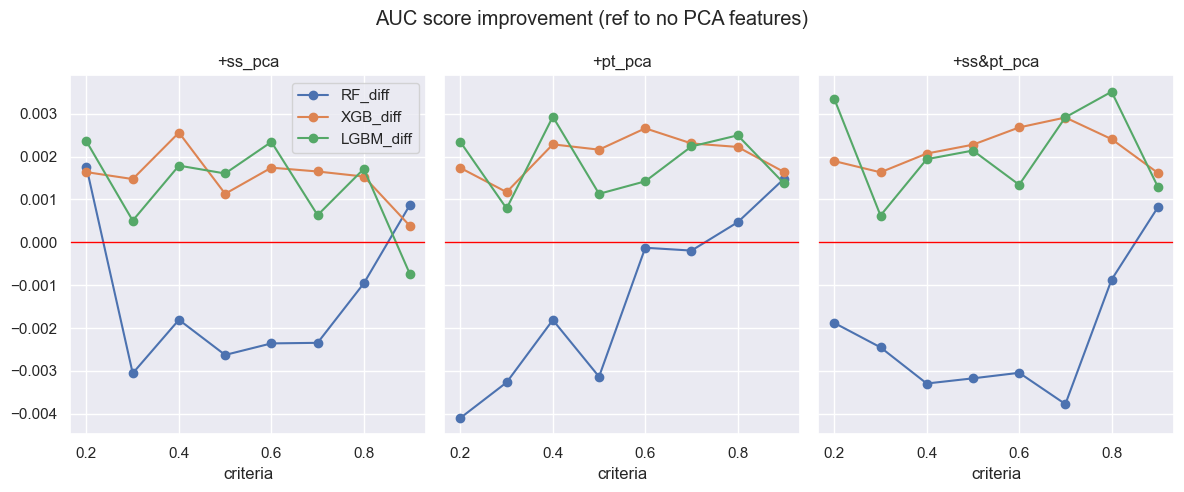

In [11]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 5))
df_summary[df_summary['features']=='+ss_pca']\
    [['criteria', 'RF_diff', 'XGB_diff', 'LGBM_diff']].\
    set_index('criteria').plot(marker='o', ax=axs[0])
df_summary[df_summary['features']=='+pt_pca']\
    [['criteria', 'RF_diff', 'XGB_diff', 'LGBM_diff']].\
    set_index('criteria').plot(marker='o', ax=axs[1])
df_summary[df_summary['features']=='+ss&pt_pca']\
    [['criteria', 'RF_diff', 'XGB_diff', 'LGBM_diff']].\
    set_index('criteria').plot(marker='o', ax=axs[2])
axs[1].get_legend().remove()
axs[2].get_legend().remove()
for i in range(3): axs[i].axhline(0, color='red', linewidth=1)
fig.suptitle('AUC score improvement (ref to no PCA features)')
axs[0].set_title('+ss_pca')
axs[1].set_title('+pt_pca')
axs[2].set_title('+ss&pt_pca')
fig.tight_layout()
fig.show()

- XGB and LGBM models generally show positive results with PCA features.
    - AUC score improvement **~ +0.003**
- RF model, on the other hand, performs worse when including PCA features.

In [13]:
# prepare submit file
df_train_scaler = pd.DataFrame(scaler.fit_transform(df_train.drop(columns=predict_features)), 
                               index=df_train.index, columns=df_train.drop(columns=predict_features).columns)
df_train_pt = pd.DataFrame(pt.fit_transform(df_train.drop(columns=predict_features)),
                           index=df_train.index, columns=df_train.drop(columns=predict_features).columns)
df_test_scaler = pd.DataFrame(scaler.transform(df_test), 
                              index=df_test.index, columns=df_test.columns)
df_test_pt = pd.DataFrame(pt.transform(df_test), 
                          index=df_test.index, columns=df_test.columns)
for criteria in [0.4, 0.5, 0.6, 0.7]:
    # generate pca features for train and test datasets
    train_ss_features, pca = get_pca(df_train_scaler, num_features, criteria, 'ss')
    test_ss_features = apply_pca(df_test_scaler, pca, 'ss')
    train_pt_features, pca = get_pca(df_train_pt, num_features, criteria, 'pt')
    test_pt_features = apply_pca(df_test_pt, pca, 'pt')
    # combine pca features into train and test datasets
    train_data = pd.concat([df_train, train_ss_features, train_pt_features], axis=1)
    test_data = pd.concat([df_test, test_ss_features, test_pt_features], axis=1)
    df_result = df_test_raw[['id']] # for output file
    for defect in predict_features:
        X_train = train_data.drop(columns=predict_features)
        y_train = train_data[defect]
        X_test = test_data.copy()
        # permutation importance
        model = LGBMClassifier(n_estimators=500, learning_rate=0.02, n_jobs=-1, verbose=-1)
        model.fit(X_train[~X_train.index.isin(val_stratify.index)],
                  y_train[~y_train.index.isin(val_stratify.index)])
        permu_importance = permutation_importance(
            estimator=model,
            X=X_train[X_train.index.isin(val_stratify.index)],
            y=y_train[y_train.index.isin(val_stratify.index)],
            scoring='roc_auc', n_repeats=5,
            n_jobs=-1, random_state=0
        )['importances_mean']
        features = []
        for i in range(X_train.shape[1]):
            feature = X_train.columns.to_list()[i]
            if permu_importance[i] > 1e-4:
                features.append(feature)
        X_train = X_train[features]
        X_test = X_test[features]
        model = LGBMClassifier(**{'n_estimators': 716,
                               'learning_rate': 0.008655141501794094,
                               'max_depth': 5,
                               'reg_alpha': 0.9522134628349151,
                               'reg_lambda': 0.07875944420059292,
                               'num_leaves': 18,
                               'subsample': 0.33327260735952596,
                               'colsample_bytree': 0.45916663480321157, 
                               'verbose': -1})
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)[:, 1]
        df_result[defect] = y_score
    df_result.to_csv(output_path + f'pca_criteria_{criteria:.1f}.csv', index=False)